In [261]:
def get_model_path(environment, model_name):
    if environment == 'Kaggle':
        model_path = '../working/' + model_name
    else:
        model_path = model_name
    return model_path

environment = ['Google_Colab','Kaggle','Jupyter_Notebook']
environment = environment[0]
environment

'Google_Colab'

In [262]:
# !pip install catboost
# !pip install folium==0.2.1
# !pip install imgaug==0.2.5
# !pip install np_utils
# !pip install -q tensorflow==2.3
# !pip install albumentations -q # аугментации изображений
# !pip install pymorphy2
# !pip install pymorphy2-dicts

In [263]:
# !pip install -U albumentations

In [264]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, MaxAbsScaler, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.decomposition import PCA

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
# %config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import collections
import seaborn as sns

x_size = 8
y_size = 5

import pymorphy2

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [265]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
Numpy        : 1.19.5
Tensorflow   : 2.3.0


In [266]:
!pip freeze > requirements.txt

# Функции

In [415]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


def getCountPlot(df, feature, x_s=x_size):
    '''
    распределение категориальных признаков
    '''
    try: # динамически определяем высоту диагаммы
        plt.figure(figsize=(x_s, df[feature].nunique()*.3))
        sns.countplot(data=df,
                order = df[feature].value_counts().index, 
                y=feature)
        plt.title(f'Распределение значений признака {feature}')
        plt.show;
    except:
        print(f'{feature} - невозможно')

def visualize_distributions(titles_values_dict):
    '''
    распределение числовых признаков
    '''
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

def get_engine_numeric(s):
    '''Для извлечения чисел из признаков engineDisplacement и enginePower'''
    # в обоих признаках числа - на первом месте в значении
    try:
        s = s.transform(lambda x: x.split()[0])
        s = s.str.replace('undefined', '0').astype(float)
    except:
        print(f'{s.name} уже преобразован')
    return s


def get_emission_limits(s):
    '''
    Границы выюросов
    '''
    perc25, perc75 = s.quantile(0.25), s.quantile(0.75)
    IQR = perc75 - perc25
    lower_bound, upper_bound = perc25 - 1.5*IQR, perc75 + 1.5*IQR
    return lower_bound, upper_bound


def get_emission_median(s):
    '''
    Замена выбросов медианой
    '''
    l_b, u_b = get_emission_limits(s)
    meaning = s.median()
    s = np.where((s < l_b) | (s > u_b), meaning, s)
    return s

def get_emission_mean(s):
    '''
    Замена выбросов средним
    '''
    l_b, u_b = get_emission_limits(s)
    meaning = s.mean()
    s = np.where((s < l_b) | (s > u_b), meaning, s)
    return s


def get_lower_dimension(df, dict_feature):
    '''
    Снижение размерности методом главных компонент
    '''
    for key in dict_feature.keys():
        result = df[dict_feature[key]].values

        # создаём экземпляр Scaler
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(result)

        # Указываем новую размерность - n_components
        pca = PCA(n_components=1)
        pca.fit(scaled_data)
        pca_data = pca.transform(scaled_data)

        # создаём новый признак
        df[key] = pca_data
        # df = df.drop(dict_feature[key],axis=1)

    return df

def get_model_plot(history):

    plt.plot(history.history['MAPE'], label='train')
    plt.plot(history.history['val_MAPE'], label='test')
    plt.title('Loss')
    plt.ylabel('MAPE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])

    plt.show()

# DATA

In [268]:
if environment == 'Google_Colab':
    DATA_DIR = '/content/drive/MyDrive/Skillfactory/Проект 7. Возьмёте Бэтмобиль?/'
elif environment == 'Kaggle':
    DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
elif environment == 'Jupyter_Notebook':
    DATA_DIR = 'Data/'


train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [269]:
display(f'train {train.shape}, test {test.shape}, sample_submission {sample_submission.shape}')

'train (6682, 22), test (1671, 21), sample_submission (1671, 2)'

# Model 1: наивная
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.


In [270]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [271]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

ОбЪединяем train и test

In [272]:
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


## Целевая переменная - price

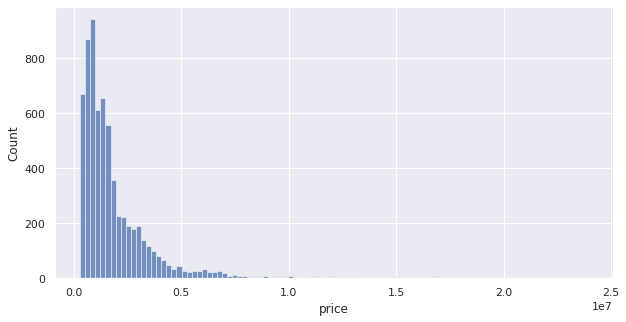

In [273]:
plt.figure(figsize=(10, 5))
sns.histplot(data=train['price'], bins=100);

Распределение сильно смещено влево. для модели целевую переменную лучше логарифмировать:

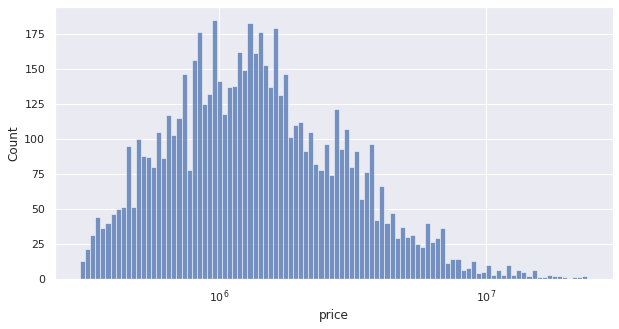

In [274]:
plt.figure(figsize=(10, 5))
sns.histplot(data=train['price'], bins=100, log_scale=True);

В таком виде точность должна быть выше.

## PANDAS PROFILING

Доступен по ссылке [report](https://drive.google.com/file/d/1vf4lte5TM6El-tSOBX0ZsKkbn0YsUB-D/view?usp=sharing)

In [275]:
# Для Colab
# pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

# from pandas_profiling import ProfileReport

In [276]:
# profile = ProfileReport(data, title="Pandas Profiling Report")
# profile.to_notebook_iframe() # развёрнутый вид
# profile.to_file("report.html") # в файл

## Пропуски данных

In [277]:
# проверим на наличие пропусков
print(f'Всего пропущенных данных {data.isna().sum().sum()}')

Всего пропущенных данных 5419


In [278]:
data.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64

* Большинство данных в прзнаке 'Владение' отсутствуют. Исключим его.
* Пропуск в признаке 'Владельцы' заменим самым частым значением

In [279]:
# data.drop(['Владение'], axis=1, inplace=True)
data['Владельцы'] = data['Владельцы'].fillna(data['Владельцы'].describe()['top'])

## Дубликаты

In [280]:
data.groupby('sell_id').size().max()

1

* Дубликатов нет

## Признаки

### bodyType

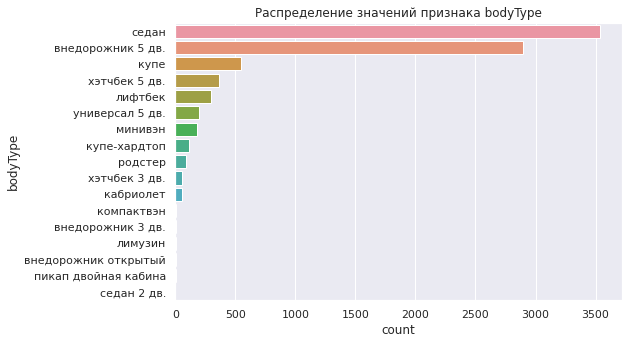

In [281]:
getCountPlot(data,'bodyType')

### brand

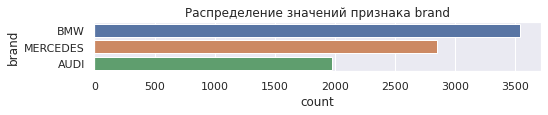

In [282]:
getCountPlot(data,'brand')

###  color

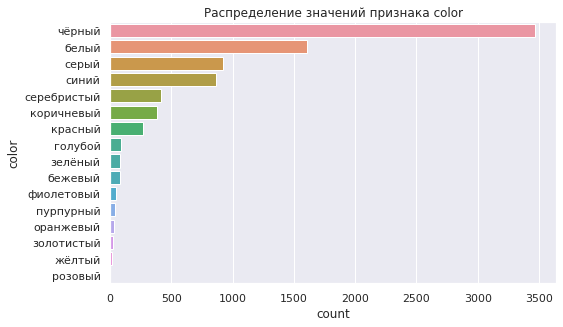

In [283]:
getCountPlot(data,'color')

### description

* Признак содержит сопроводительный текст продавца к объявлению о продаже. Текст неоднородный (по характереру может быть похож как на разговорную речь, так и фомальное рекламное объявление с описанием комплектации автомобиля. 

* В тексте много "шума" - пробельные символы, цифры, сокращения и т.д. и т.п.

* Требуется обработка

In [284]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object


* Из description можно создать числовой признак - количество символов в описании. Логика в этом следующая - чем более продавец заинтересован в реализации автомобиля (скорее всего за более высокую цену), тем более полное описание он даст в объявлении. Следовательно этот признак может иметь влияние на целевую переменную.

* По составу объявления (ключевые слова) можно предположить кто является продавцом - частное лицо или автосалон. В автосалоне вероятно цена будет выше на аналогичные автомобили. Можно выделить в отдельный признак.

### engineDisplacement

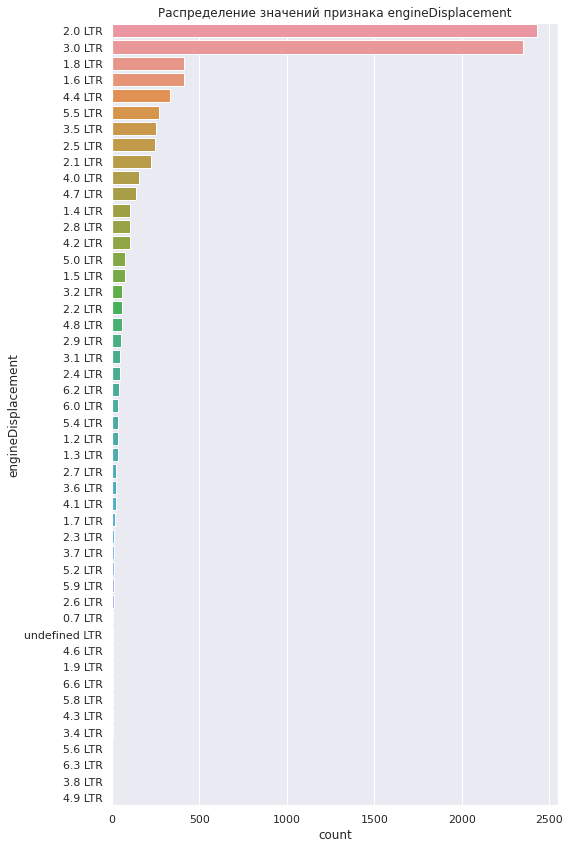

In [285]:
getCountPlot(data,'engineDisplacement')

Есть значение признака без указания объёма двигателя:

In [286]:
data[data['engineDisplacement']=='undefined LTR'].groupby(['brand',
                                                  'name',
                                                  'fuelType',
                                                  'enginePower'])['sell_id'].count()

brand  name                    fuelType  enginePower
BMW    Electro AT (126 кВт)    электро   170 N12        5
       S Electro AT (136 кВт)  электро   184 N12        1
Name: sell_id, dtype: int64

Это электромобили.

### enginePower

In [287]:
data['enginePower'].unique()

array(['220 N12', '313 N12', '218 N12', '136 N12', '190 N12', '340 N12',
       '245 N12', '316 N12', '170 N12', '160 N12', '231 N12', '388 N12',
       '180 N12', '367 N12', '115 N12', '184 N12', '177 N12', '455 N12',
       '422 N12', '163 N12', '249 N12', '272 N12', '224 N12', '122 N12',
       '557 N12', '333 N12', '306 N12', '156 N12', '150 N12', '264 N12',
       '450 N12', '555 N12', '407 N12', '130 N12', '400 N12', '204 N12',
       '469 N12', '192 N12', '210 N12', '211 N12', '239 N12', '200 N12',
       '350 N12', '420 N12', '300 N12', '381 N12', '265 N12', '258 N12',
       '390 N12', '197 N12', '120 N12', '544 N12', '193 N12', '235 N12',
       '233 N12', '394 N12', '355 N12', '421 N12', '320 N12', '585 N12',
       '105 N12', '280 N12', '194 N12', '132 N12', '639 N12', '250 N12',
       '335 N12', '510 N12', '116 N12', '360 N12', '238 N12', '225 N12',
       '625 N12', '571 N12', '507 N12', '286 N12', '372 N12', '575 N12',
       '408 N12', '310 N12', '354 N12', '255 N12', 

Преобразуем в числовой признак

### name

In [288]:
print(data['name'].nunique())
data['name'].unique()#[:5]

976


array(['300 3.0 AT (220 л.с.)', '640d xDrive 3.0d AT (313 л.с.) 4WD',
       '325xi 2.5 AT (218 л.с.) 4WD', '318i 2.0 AT (136 л.с.)',
       '520d xDrive 2.0d AT (190 л.с.) 4WD',
       '540i xDrive 3.0 AT (340 л.с.) 4WD', '3.0d AT (245 л.с.) 4WD',
       '350 3.5 AT (316 л.с.)', '1.8 CVT (170 л.с.)',
       '1.8 CVT (160 л.с.)', '300 3.0 AT (231 л.с.)',
       '320i 2.2 AT (170 л.с.)', '500 5.5 AT (388 л.с.) 4WD',
       '2.0 CVT (180 л.с.)', '650i 4.8 AT (367 л.с.)',
       '116i 1.6 AT (115 л.с.)', '320i 2.0 AT (184 л.с.)',
       '25d 3.0d AT (218 л.с.) 4WD', '20d 2.0d AT (177 л.с.) 4WD',
       '500 4.7 AT (455 л.с.) 4WD', '330i 3.0 AT (231 л.с.)',
       '1.8 AMT (190 л.с.)', '500 4x4 4.0 AT (422 л.с.) 4WD',
       '200 2.0 AT (184 л.с.) 4WD', '1.8 CVT (163 л.с.)',
       '320d 2.0d AT (163 л.с.)', '118i 1.5 AT (136 л.с.)',
       '30d 3.0d AT (249 л.с.) 4WD', '630i 3.0 AT (272 л.с.)',
       '2.4 CVT (177 л.с.)', '318i 1.5 AT (136 л.с.)',
       '320 3.0d AT (224 л.с.) 4WD', '2.

* Очень много уникальных значений - нужно извлечь данные для отдельных признаков
* Извлечь и проанализировать частоту текстовых лексем(BlueTEC, long, xDrive и т.д.) - если нет пересечений с другими признаками - создать новые.
* Извлечь из скобок мощность двигателя в лошадиных силах и посчитать сумму транспортного налога, получив таким образов новый категориальный признак.

### fuelType

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64

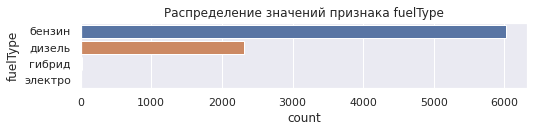

In [289]:
getCountPlot(data,'fuelType')
data.fuelType.value_counts()

### modelDate, productionDate

Два очень похожих признака, наверняка будут сильно коррелировать

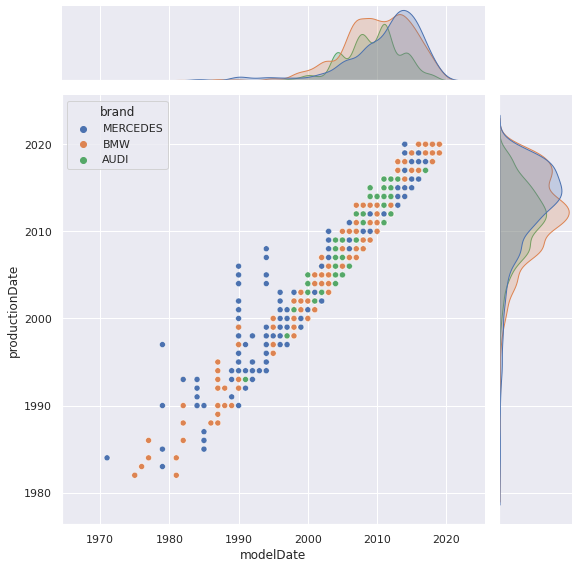

In [290]:
sns.jointplot(data=data, x='modelDate', y='productionDate', hue='brand',height=8);

* Ожидаемо плотное взаимное распределение.
* Но видны "модели-долгожители" - можно создать отдельный признак "Возраст модели на момент выпуска" (ageRelease) - разница между датой выпуска и датой модели.
* Можно создать признак "Возраст автомобиля" (ageCar) - разница между текущим годом и годом выпуска.
* Можно вычислить и вывести в отдельный признак например "Коэффициент жизни модели" (k_model_life) - отношение года модели к году выпуска.
* Чтобы снизить корреляцию можно productionDate - оставить в категориальных данных, а modelDate - в числовых
> P.S. Был проведён эксперимент - оба признака переведены в числовые и объединины в один признак методом главных компонент, но это ухудшило метрику.



### model_info

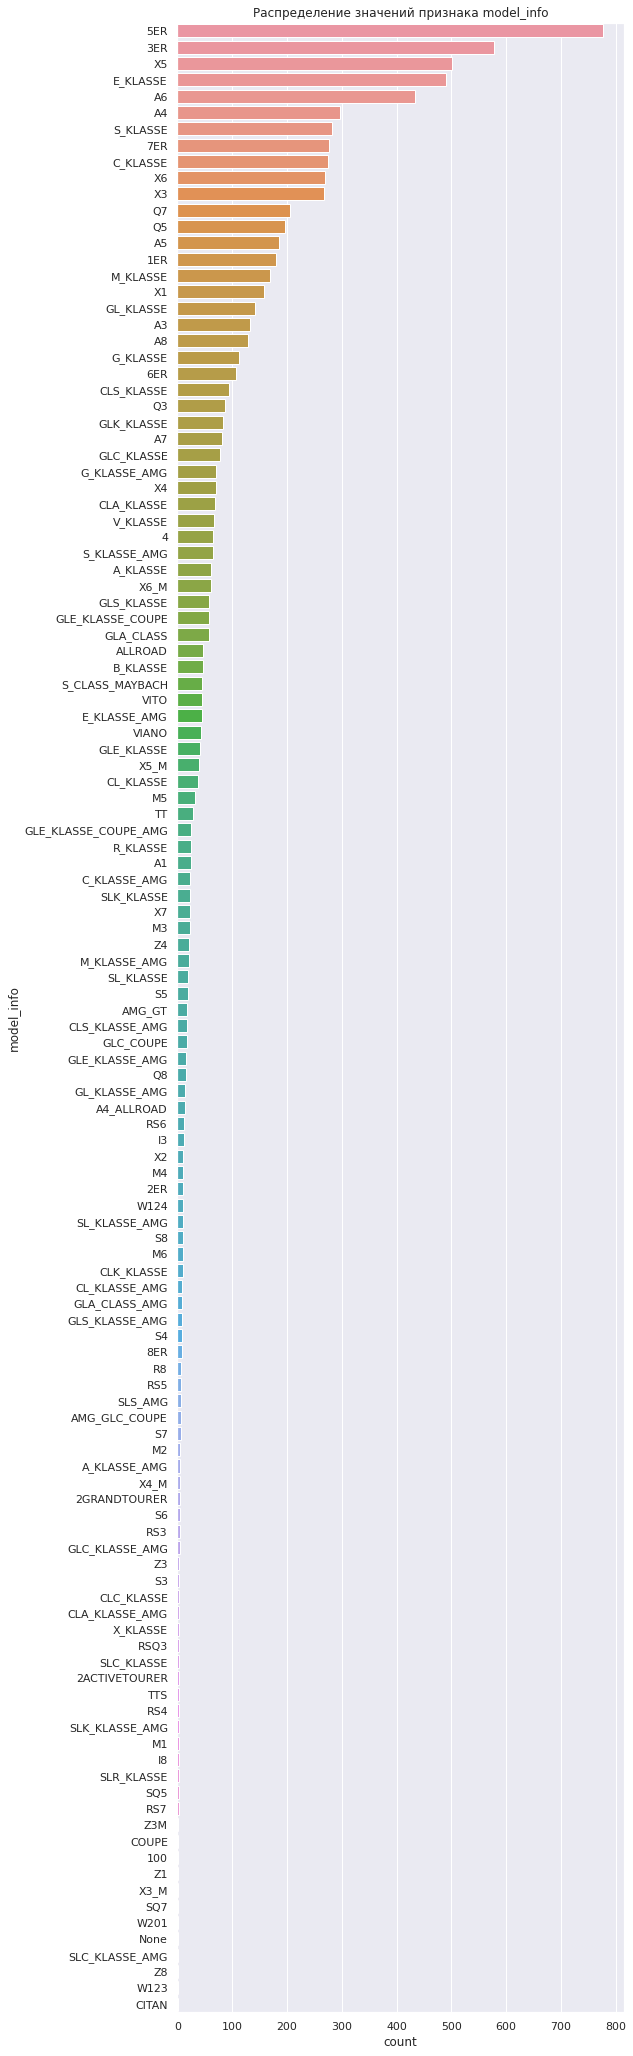

In [291]:
getCountPlot(data,'model_info')

### numberOfDoors

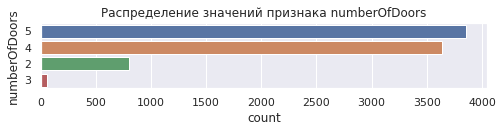

In [292]:
getCountPlot(data,'numberOfDoors')

### vehicleConfiguration

In [293]:
# getCountPlot(data,'vehicleConfiguration')
data['vehicleConfiguration'].unique()[:5]

array(['WAGON_5_DOORS AUTOMATIC 3.0', 'COUPE AUTOMATIC 3.0',
       'COUPE AUTOMATIC 2.5', 'SEDAN AUTOMATIC 2.0',
       'SEDAN AUTOMATIC 3.0'], dtype=object)

* содержит полностью дублирующие другие признаки значения - можно удалить из модели

### vehicleTransmission

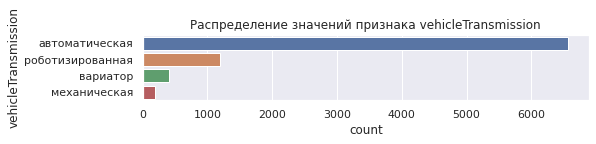

In [294]:
getCountPlot(data,'vehicleTransmission')

### Владельцы

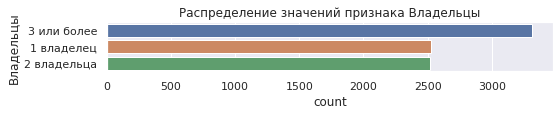

In [295]:
getCountPlot(data,'Владельцы')

### Привод

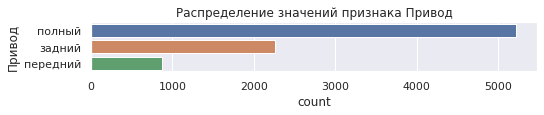

In [296]:
getCountPlot(data,'Привод')

### ПТС

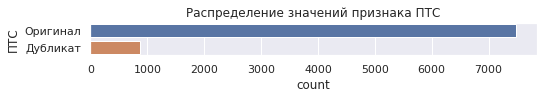

In [297]:
getCountPlot(data,'ПТС')

### Руль

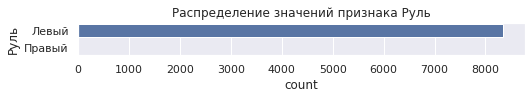

In [298]:
getCountPlot(data,'Руль')

### mileage

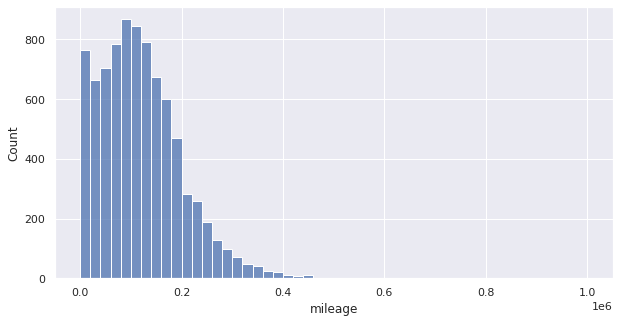

In [299]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data['mileage'], bins=50);

Есть автомобили с пробегом под 1 млн. километров. Посмотрим на них

In [300]:
data[data['mileage']>999000].groupby(['brand', 'mileage','productionDate'])['sell_id'].count()

brand     mileage  productionDate
MERCEDES  999999   2008              1
          1000000  1994              1
Name: sell_id, dtype: int64

# FEATURE INGENERING

1. enginePower - в числовой
2. name:
    * Анализируем отдельные лексемы, выделяем особенные

## enginePower - в числовой

In [301]:
# очистим
data['enginePower'] = data['enginePower'].astype(str)
data['enginePower'] = data['enginePower'].str.replace(' N12', '')
data['enginePower'] = data['enginePower'].astype(int)

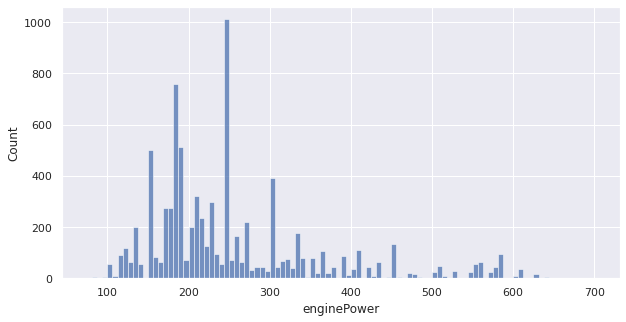

In [302]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='enginePower', bins=100);

##  Blue, xDrive, sDrive, Long, AMG_Brabus, AT_AMT

In [303]:
# Выделяем из 'name' отдельные признаки 
c = collections.Counter()

# разбираем на лексемы уникальные значения признака
for i in data['name']:
    text = re.sub('[^\w\.]', ' ', i).split()
    for word in text:
        c[word] += 1
# Самые высокачастотные лексемы в значениях 'name'
c.most_common(100)
# sum(c.values())

[('л.с.', 8347),
 ('AT', 6560),
 ('4WD', 5218),
 ('2.0', 1792),
 ('3.0d', 1329),
 ('AMT', 1201),
 ('3.0', 1058),
 ('xDrive', 933),
 ('184', 758),
 ('249', 655),
 ('2.0d', 635),
 ('350', 552),
 ('200', 505),
 ('190', 420),
 ('1.8', 411),
 ('1.6', 409),
 ('CVT', 406),
 ('180', 361),
 ('AMG', 356),
 ('245', 355),
 ('306', 344),
 ('4.4', 326),
 ('211', 310),
 ('Long', 304),
 ('500', 287),
 ('d', 284),
 ('150', 280),
 ('170', 275),
 ('5.5', 268),
 ('63', 261),
 ('250', 261),
 ('3.5', 245),
 ('30d', 244),
 ('218', 233),
 ('2.5', 230),
 ('156', 223),
 ('CDI', 221),
 ('2.1d', 221),
 ('320i', 217),
 ('272', 206),
 ('136', 201),
 ('MT', 186),
 ('231', 179),
 ('204', 174),
 ('300', 170),
 ('20d', 164),
 ('400', 163),
 ('35i', 161),
 ('333', 160),
 ('258', 160),
 ('520d', 157),
 ('320', 145),
 ('220', 144),
 ('4.0', 144),
 ('4.7', 137),
 ('BlueTEC', 136),
 ('450', 130),
 ('177', 129),
 ('520i', 118),
 ('1.4', 106),
 ('2.8', 106),
 ('367', 105),
 ('4.2', 103),
 ('530d', 103),
 ('20i', 96),
 ('122',

Из тех, значений, которые не представлены в других признаках, можно выделить:
* xDrive (особая полноприводная система BMW)
* sDrive (одноосная система BMW)
* Long, длинный (удлиннённый кузов Mercedes и AUDI)
* Blue... - система экономии топлива
* AMG, Brabus - признак тюнинга
* AT, AMT - варианты АКПП



Выделим их в отдельные бинарные признаки.

In [304]:
# Приведём разные по виду, но одинаковые по смыслу лексемы к одному виду
def func_name_replace(text):
    r_text = re.sub('длинный', 'Long', text)
    r_text = re.sub('AMG|Brabus', 'AMG_Brabus', r_text)
    r_text = re.sub('AT|AMT', 'AT_AMT', r_text)
    return r_text


data['name'] = data['name'].apply(lambda x: func_name_replace(x))

In [305]:
# Создаём новые признаки 
for col in ['Blue','xDrive','sDrive','Long','AMG_Brabus','AT_AMT']:
    data[col] = np.where(data['name'].str.contains(col, case=False), 1, 0)

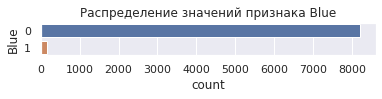

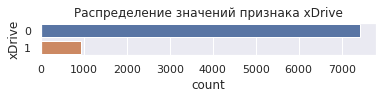

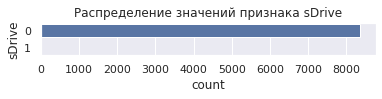

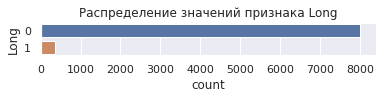

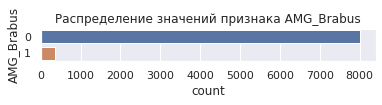

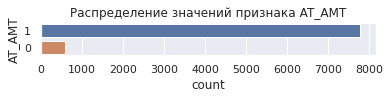

In [306]:
for feature in ['Blue','xDrive','sDrive','Long','AMG_Brabus','AT_AMT']:
    getCountPlot(data,feature,6)

## power, tax, gr_tax

Создадим 3 признака
* Мощность двигателя в л.с.
* Величина транспортного налога в рублях (для Москвы)
* Налоговая группа (под какую ставку попадает автомобиль)

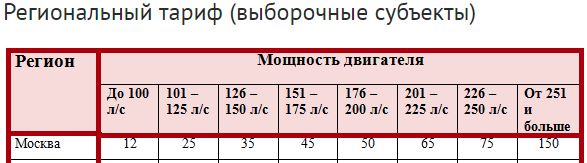

Источник: [ФНС РОССИИ](https://www.nalog.gov.ru/rn77/service/tax/d988573/)

In [307]:
# Вычислим налог, группу и мощность в лошадиных силах
def get_tax(s):
    df = pd.DataFrame(columns=['tax','gr_tax'])
    # извлекаем лошадные силы
    power = s.str.extract('\(([^)]\d+)').astype(int)
    power.columns = ['power']
    df = pd.concat((power,df), axis=1)

    # мощность-ставка
    dict_tax = {100:12, 125:25, 150:35, 175:45, 200:50, 225:65, 250:75, 251:150} 

    for i in dict_tax:
        if i == 251:
            mask = df['power'] >= 250
        else:
            mask = df['power'] < i
        df['tax'] = np.where(mask, df['power']*dict_tax[i], df['tax'])
        df['gr_tax'] = np.where(mask, 'power_' + str(i), df['gr_tax'])
    
    df['tax'] = df['tax'].astype(int)
    return df
df = get_tax(data['name'])
data = pd.concat([data,df], axis=1)
# df.head()

In [308]:
# plt.figure(figsize=(10, 5))
# sns.histplot(data=data, x='tax', bins=10, log_scale=True);

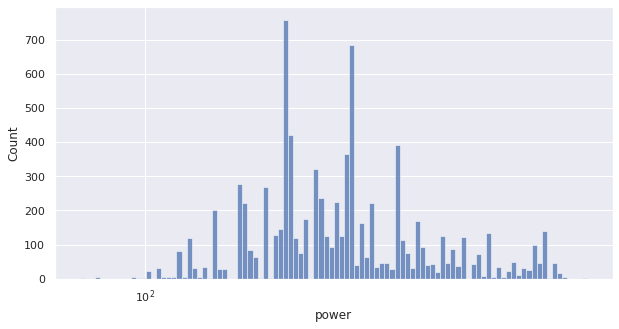

In [309]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='power', bins=100, log_scale=True);

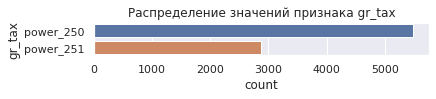

In [310]:
getCountPlot(data,'gr_tax',6)

## description_len, car_showroom

Видно, что текст "грязный". Чистим от лишних пробельных символов: 

In [311]:
data.description = data.description.str.replace(r'\s+', ' ', regex=True)

In [312]:
# создадим новый числовой признак 
data['description_len'] = data['description'].apply(lambda x: len(str(x)))

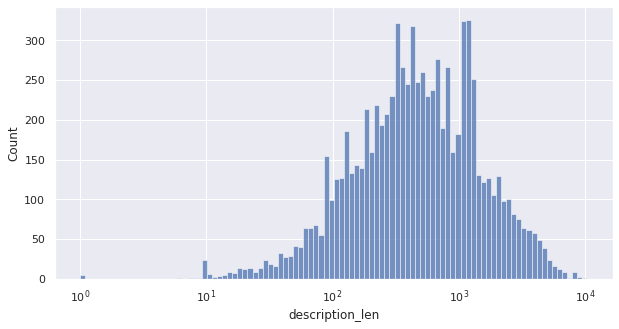

In [313]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='description_len', bins=100, log_scale=True);

description_len - нужно логарифмировать

In [314]:
data.description.value_counts().head(50)

Выгода до 82 000 руб. при обмене на Ваш автомобиль! Выгода при покупке в кредит до 100 000 руб.! РОЛЬФ ЯСЕНЕВО с пробегом. -Мы принимаем любые легковые и коммерческие автомобили независимо от марки, года выпуска, пробега и состояния автомобиля. -В наличии более 500 проверенных и готовых к продаже автомобилей. -Более 400 комплектов шин, дисков, колес в сборе. -Все автомобили проходят комплексную проверку - техническую, криминалистическую, проверку истории кузовных ремонтов сертифицированными специалистами. -Мы предоставляем гарантию юридической чистоты в соответствии с законодательством РФ. -Мы работаем каждый день с 9:00 до 22:00 (без выходных). Услуги: • Срочный выкуп Вашего автомобиля • Выкуп кредитных а/м • Trade-in - обмен Вашего автомобиля на новый или с пробегом (возможна доплата с любой стороны) • Выездная оценка Вашего а/м • Комиссионная продажа (на Ваших условиях) • Аукцион • Кредитование • Страхование КАСКО, ОСАГО • Дополнительное оборудование • Запасные части • Сервисное обс

* С помощью `data.description.value_counts()` выяснили, что все объявления, повторяющиеся более 3 раз можно однозначно отнести к автосалонам.
* Выделим их в отдельный корпус текстов, разделим на предложения (учтем только предложения больше заданной длинны).




In [315]:
# количество объявлений автосалонов, полученное на первом этапе
mask = data.description.isin(data.description.value_counts().loc[lambda x: x > 3].index)
df = data[mask]
print(f'Объявлений от автосалонов: {len(df)}')

Объявлений от автосалонов: 694


In [316]:
# Определим в каких объявлениях встречаются найденные предложения: 

def get_lexem(s, mim_len):
    '''
    s - Pandas Series
    mim_len - минимальная длина предложения
    '''
    c = collections.Counter()
    # разбираем объявления на предложения
    for row in s:
        for text in row.split('.'):
            sent = text.strip()
            if len(sent) >= mim_len:
                c[sent] += 1
    return c

# учитываем предложения(строки) от 5 символов
c = get_lexem (df.description, 5)
# c.most_common(1000)

df = data[data['description'].str.contains('|'.join(list(c)))]
print(f'Объявлений от автосалонов: {len(df)}')

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Объявлений от автосалонов: 1009


Интуитивно примерная пропорция 1 к 8 (1 объявление от автосалона на 8 объявлений частных лиц) кажется вполне достоверной. Можно выделить в отдельный признак.

In [317]:
mask = data['description'].str.contains('|'.join(list(c)))
df = pd.DataFrame(columns=['car_showroom'])
data = pd.concat([data, df], axis=1)
data['car_showroom'] = np.where(mask, 1, 0)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


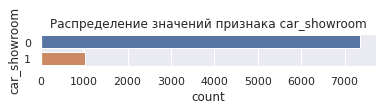

In [318]:
getCountPlot(data,'car_showroom',6)

## ageRelease, ageCar, k_model_life

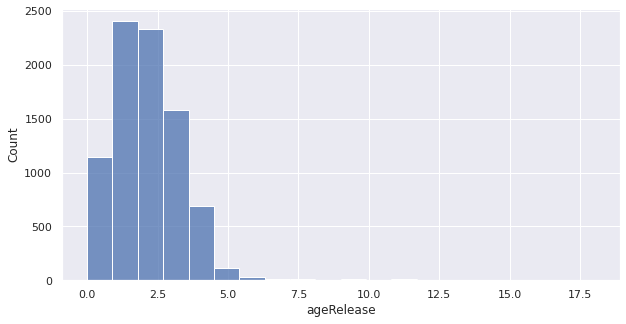

In [319]:
# разница между датой выпуска и датой модели
data['ageRelease'] = data['productionDate'] - data['modelDate']
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='ageRelease', bins=20);

In [320]:
# # разница между текущим годом и годом выпуска
# data['ageCar'] = 2021 - data['productionDate']
# plt.figure(figsize=(10, 5))
# sns.histplot(data=data, x='ageCar', bins=20); #, log_scale=True

In [321]:
# # отношение года модели к году выпуска
# data['k_model_life'] = data['modelDate'] / data['productionDate']
# plt.figure(figsize=(10, 5))
# sns.histplot(data=data, x='k_model_life', bins=20); #, log_scale=True

## average_mileage


Создадим новый признак "среднегодовой пробег" - "average_mileage"

In [322]:
data['average_mileage'] = data['mileage'] / (2021 - data['productionDate'])

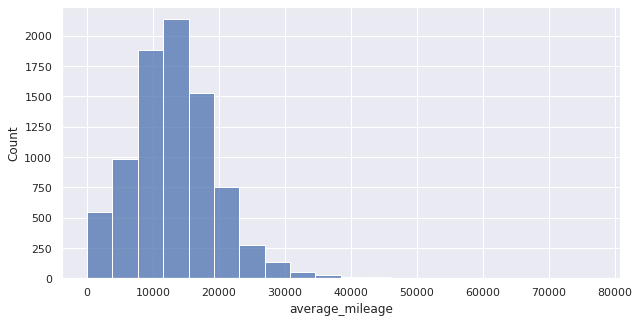

In [323]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='average_mileage', bins=20); #, log_scale=True

# Подготовка данных

In [324]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8353 entries, 0 to 8352
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   int64  
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [325]:
# # Категориальные признаки
# cat_cols = ['bodyType','brand','color','engineDisplacement','fuelType','model_info',
#             'productionDate','vehicleTransmission','Владельцы',
#             'Привод','gr_tax','numberOfDoors','modelDate']
# # бинарные
# bin_cols = ['ПТС','Руль','Blue','xDrive','sDrive','Long','AMG_Brabus','AT_AMT',
#             'car_showroom']
# # Количественные
# nom_cols = ['enginePower','mileage','description_len','tax',
#             'ageRelease','ageCar','k_model_life','average_mileage']

# # del
# del_cols = ['name','vehicleConfiguration','power']

nom_cols = ['enginePower','mileage','modelDate','productionDate','description_len',
            'average_mileage','ageRelease']
            # 'ageCar'] #,'k_model_life','tax'


In [326]:
# data.drop(columns=del_cols, inplace=True)

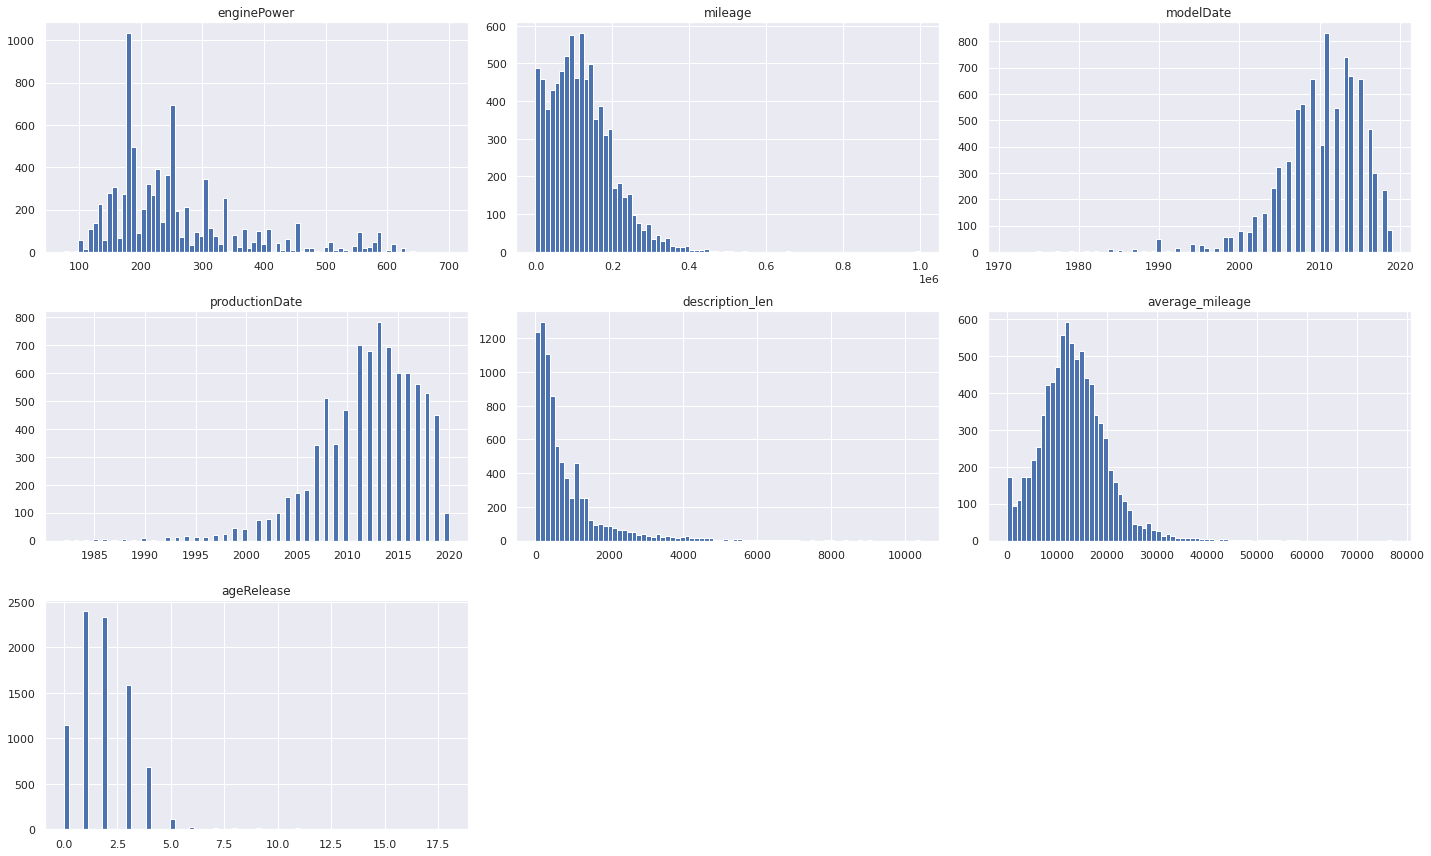

In [327]:
data[nom_cols].hist(figsize=(20, 12), bins=80);
plt.tight_layout()

## Выбросы

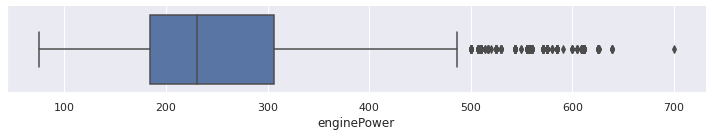

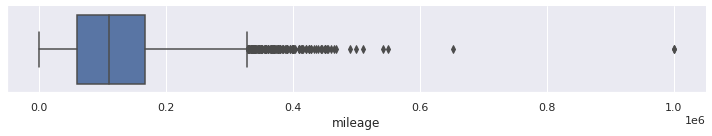

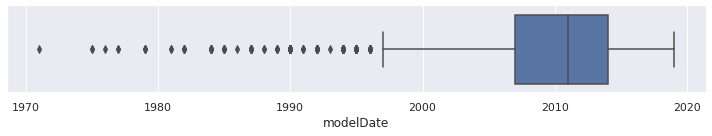

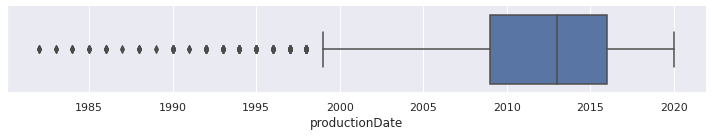

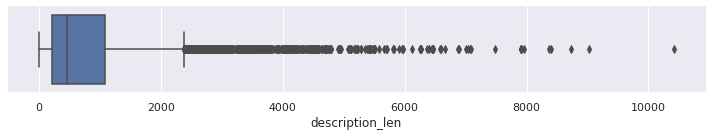

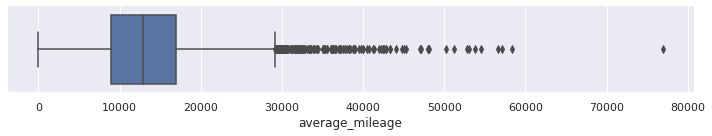

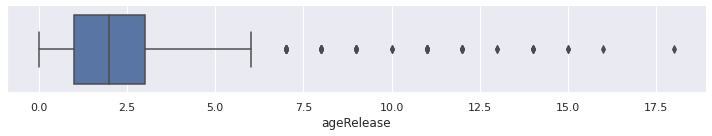

In [328]:
# Смотрим на выбросы
for col in nom_cols:
    sns.catplot(x=col, data=data, kind="box", height=2, aspect=5, orient ='h'); 

Обработаем выбросы:

In [329]:
 # заменим выбросы средним (медиана хуже)
for col in ['description_len']:
    data[col] = get_emission_mean(data[col])

## Нормализация

Некоторые числовые признаки требуется логарифмировать

In [330]:
for col in ['productionDate','modelDate']:
    data[col]  = np.log(2021 - data[col])

In [331]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
for column in nom_cols:
    data[column] = scaler.fit_transform(data[[column]])[:, 0]

data[nom_cols].sample(2)

,enginePower,mileage,modelDate,productionDate,description_len,average_mileage,ageRelease
7399,-0.09699,-0.163258,-0.633232,-0.361264,0.27317,0.683890,-0.632606
4273,-0.09699,-0.920726,-0.370056,-0.649239,0.14323,-0.644139,0.761999


## Label Encoding

In [332]:
# Кодируем категориальные признаки

cat_cols = ['bodyType', 'brand', 'color', 'engineDisplacement','fuelType',
            'model_info','numberOfDoors', 'vehicleTransmission','Владельцы',
            'ПТС', 'Привод', 'Руль','gr_tax','Blue','xDrive','sDrive','Long',
            'AMG_Brabus','AT_AMT','car_showroom']

for column in cat_cols:
    data[column] = data[column].astype('category').cat.codes

data[cat_cols].sample(2)

,bodyType,brand,color,engineDisplacement,fuelType,model_info,numberOfDoors,vehicleTransmission,Владельцы,ПТС,Привод,Руль,gr_tax,Blue,xDrive,sDrive,Long,AMG_Brabus,AT_AMT,car_showroom
3640,16,0,11,9,0,12,3,3,0,1,2,0,0,0,0,0,0,0,1,0
6421,1,1,15,9,0,105,3,0,1,1,0,0,0,0,0,0,0,0,1,0


## Значимость признаков

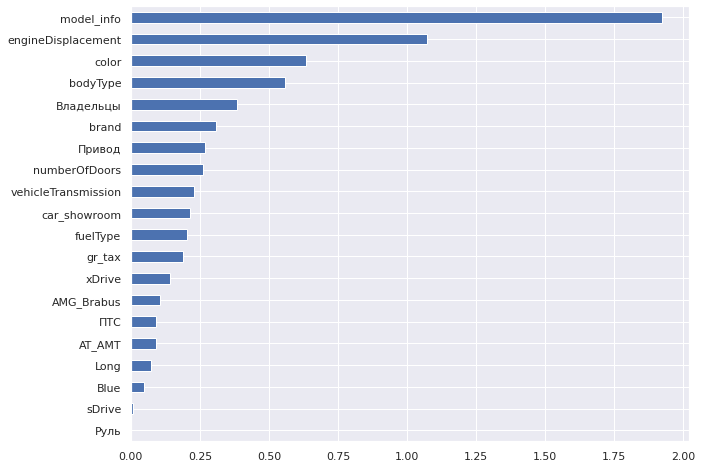

In [333]:
# Категориальные 
df = data[data['sample'] == 1][cat_cols + ['price']]
df = pd.Series(mutual_info_classif(df[cat_cols],
                                       df['price'], 
                                       discrete_features=True), index=[cat_cols][0])
df.sort_values(inplace=True)
plt.figure(figsize=(10, 8))
df.plot(kind='barh');

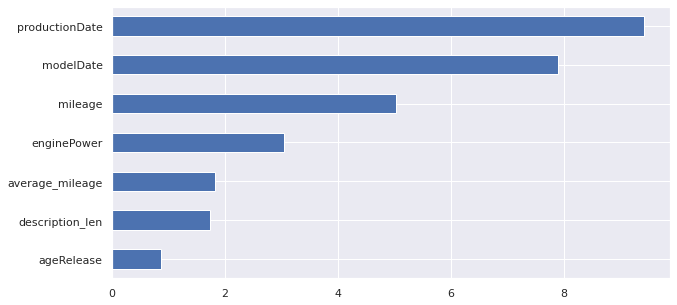

In [334]:
# Числовые 
df = data[data['sample'] == 1][nom_cols + ['price']]
df = pd.Series(f_classif(df[nom_cols], df['price'])[0], index=[nom_cols][0])
df.sort_values(inplace=True)
plt.figure(figsize=(10, 5))
df.plot(kind='barh');

## Корреляции признаков

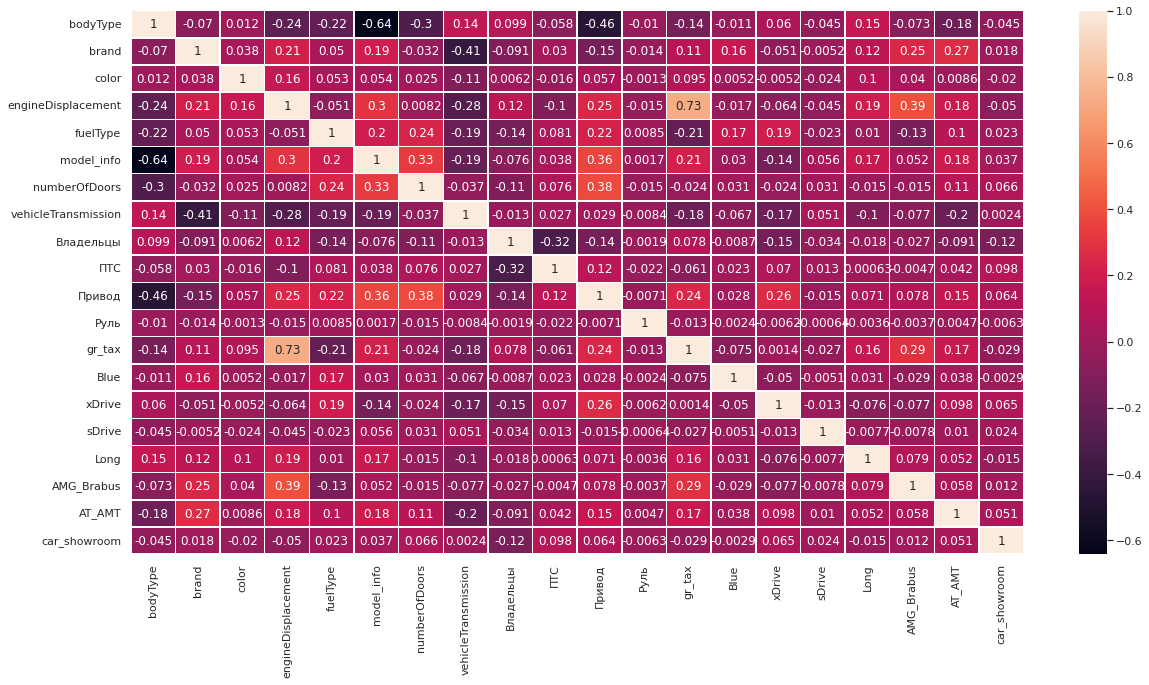

In [335]:
# Категориальные 
df = data[data['sample'] == 1][cat_cols]
sns.set(rc = {'figure.figsize':(20,10)})
sns.heatmap(df[cat_cols].corr(), annot=True, linewidths=.5);

Очень сильных корреляций нет

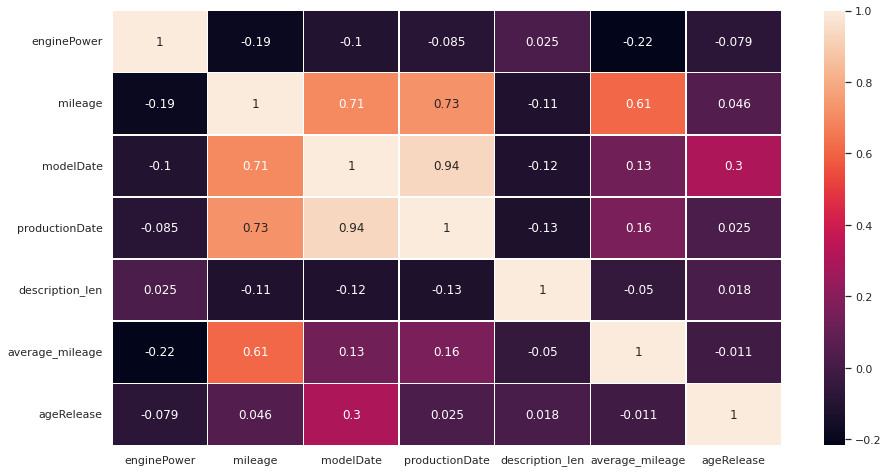

In [336]:
# Номинативные
df = data[data['sample'] == 1][nom_cols]
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df[nom_cols].corr(), annot=True, linewidths=.5);

In [337]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8353 entries, 0 to 8352
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   int8   
 1   brand                 8353 non-null   int8   
 2   color                 8353 non-null   int8   
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   int8   
 5   enginePower           8353 non-null   float64
 6   fuelType              8353 non-null   int8   
 7   mileage               8353 non-null   float64
 8   modelDate             8353 non-null   float64
 9   model_info            8353 non-null   int8   
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int8   
 12  productionDate        8353 non-null   float64
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

## ИТОГИ ПРЕДОБРАБОТКИ
* Произведен анализ целевой переменной - в модели к ней необходимо применить логарифм
* Ликвидированы пропуски данных (от одного признака с большим количеством пропусков решено отказаться)
* Дубликатов не найдено
* Признаки обработаны, разделены на номинативные, категориальные и бинарные
* Созданы новые признаки
* Выбросы - обрботаны
* Нормализация - применена
* Кодирование - применено
* Выявлены наиболее значимые для целевой переменной признаки
* Корреляционный анализ - проведён

# ML

Завернём всю обработку в функцию

In [338]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    

    # ################### Предобработка #####################################

    # перевод в числовой
    df_output['enginePower'] = df_output['enginePower'].str.replace(' N12', '')
    df_output['enginePower'] = df_output['enginePower'].astype(int)

    # ################### Feature Engineering ##################################

    # генерим фичи из name 
    df_output['name'] = df_output['name'].apply(lambda x: func_name_replace(x))
    for col in ['Blue','xDrive','sDrive','Long','AMG_Brabus','AT_AMT']:
        df_output[col] = np.where(df_output['name'].str.contains(col, case=False), 1, 0)
    
    df = get_tax(df_output['name'])
    df_output = pd.concat([df_output, df], axis=1)

    # description_len
    # df_output.description = df_output.description.str.replace(r'\s+', ' ', regex=True)
    df_output['description_len'] = df_output['description'].apply(lambda x: len(str(x)))

    # car_showroom
    mask = df_output.description.isin(df_output.description.value_counts().loc[lambda x: x > 3].index)
    df = df_output[mask]
    c = get_lexem (df.description, 5)
    mask = df_output['description'].str.contains('|'.join(list(c)))
    df = pd.DataFrame(columns=['car_showroom'])
    df_output = pd.concat([df_output, df], axis=1)
    df_output['car_showroom'] = np.where(mask, 1, 0)


    # разница между датой выпуска и датой модели    
    df_output['ageRelease'] = df_output['productionDate'] - df_output['modelDate']

    # разница между текущим годом и годом выпуска
    # df_output['ageCar'] = 2021 - df_output['productionDate']

    # отношение года модели к году выпуска
    # df_output['k_model_life'] = df_output['modelDate'] / df_output['productionDate']

    # средний пробег в год 
    df_output['average_mileage'] = df_output['mileage'] / (2021 - df_output['productionDate'])


    # заменим выбросы средним (медиана хуже)
    df_output['description_len'] = get_emission_mean(df_output['description_len'])

    
    # ################### Нормализация #########################################

    # Нормализация данных

    # логарифмируем даты
    for col in ['productionDate','modelDate']:
            df_output[col]  = np.log(2022 - df_output[col]) #??

    # scaler = MinMaxScaler()
    # scaler = MaxAbsScaler()
    scaler = StandardScaler()
    # scaler = RobustScaler()
    for column in nom_cols:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    
    # ################### Clean ################################################
    # убираем не нужные для модели признаки
    col = set(df_output.columns)
    col ^= set(nom_cols + cat_cols + ['price','sample'])
    df_output.drop(list(col), axis = 1, inplace=True)
    
    
    # ################### Encoding #############################################
    # Label Encoding
    for column in cat_cols:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding
    df_output = pd.get_dummies(df_output, columns=cat_cols, dummy_na=False)
 
    
    return df_output

In [339]:
df = test.append(train, sort=False).reset_index(drop=True) # объединяем

# Запускаем и проверяем, что получилось
df_preproc = preproc_data(df)
df_preproc.sample(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,enginePower,mileage,modelDate,productionDate,sample,price,description_len,ageRelease,average_mileage,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,...,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_-1,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,gr_tax_0,gr_tax_1,Blue_0,Blue_1,xDrive_0,xDrive_1,sDrive_0,sDrive_1,Long_0,Long_1,AMG_Brabus_0,AMG_Brabus_1,AT_AMT_0,AT_AMT_1,car_showroom_0,car_showroom_1
423,-0.969532,-0.505340,0.415727,0.250748,0,0.0,-1.105816,0.761999,-0.677549,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0
1079,-0.877685,0.691946,0.733405,0.591860,0,0.0,0.858749,0.761999,0.421929,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
4964,-0.969532,-1.162077,-2.200841,-2.001813,1,1945000.0,0.321017,-0.632606,-0.099522,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0
1509,0.150995,0.972942,0.733405,1.009348,0,0.0,-0.276894,-1.329908,0.150530,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0
7186,-0.060252,0.522530,-0.400608,-0.166740,1,2504855.0,0.942224,-0.632606,1.506473,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0
2891,0.463273,0.728598,0.415727,0.429067,1,1200000.0,-0.966045,0.064696,0.708947,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,1
4215,-0.060252,-1.085377,-0.958516,-1.463577,1,3329000.0,1.410070,0.761999,-0.417472,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1
1382,-1.033824,1.730409,1.480360,1.547584,0,0.0,-0.061413,-0.632606,0.075924,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0
3995,-0.657254,0.239910,-1.300724,-0.704976,1,1750000.0,-1.008753,-1.329908,2.212376,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0
4689,1.960371,-1.258910,-1.705471,-2.001813,1,10745000.0,0.397312,0.064696,-0.695331,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0


In [340]:
# df_preproc.columns.to_list()

In [341]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8353 entries, 0 to 8352
Columns: 254 entries, enginePower to car_showroom_1
dtypes: float64(8), int64(1), uint8(245)
memory usage: 2.6 MB


## Split data

In [342]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [343]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 253 entries, enginePower to car_showroom_1
dtypes: float64(8), uint8(245)
memory usage: 517.3 KB


# Model 2: CatBoostRegressor

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Гиперпараметры (поиск по сетке)

In [345]:
# %%time
# model = CatBoostRegressor(iterations = 10000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['RMSE', 'MAE'],
#                           metric_period=10
#                          )
# grid = {'depth': [3,4,5,6,7,8,9,10],
#         'l2_leaf_reg': [2, 2.5 , 3, 3.5, 4, 4.5],
#         'random_strength': [0.01, 0.05, 0.06, 0.07, 0.9]}


# grid_search_result = model.grid_search(grid,
#                                        X = X_train,
#                                        y = np.log(y_train),
#                                        verbose = False)

# best_params = grid_search_result['params']
# print('\nНаилучшие параметры: ', best_params)

In [346]:
best_params = {'depth': 3, 'random_strength': 0.01, 'l2_leaf_reg': 2.5}

In [347]:
%%time
model = CatBoostRegressor(**best_params,
                          iterations = 10000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          metric_period=10,
#                           od_wait=500
                         )

model.fit(X_train, np.log(y_train),
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=100,
          use_best_model=True
         )

0:	learn: 0.0416960	test: 0.0417437	best: 0.0417437 (0)	total: 2.81ms	remaining: 28.2s
100:	learn: 0.0138679	test: 0.0135259	best: 0.0135259 (100)	total: 184ms	remaining: 18.1s
200:	learn: 0.0113566	test: 0.0110507	best: 0.0110507 (200)	total: 369ms	remaining: 18s
300:	learn: 0.0106654	test: 0.0104479	best: 0.0104479 (300)	total: 555ms	remaining: 17.9s
400:	learn: 0.0102475	test: 0.0101082	best: 0.0101082 (400)	total: 740ms	remaining: 17.7s
500:	learn: 0.0099839	test: 0.0099498	best: 0.0099498 (500)	total: 908ms	remaining: 17.2s
600:	learn: 0.0097790	test: 0.0098067	best: 0.0098067 (600)	total: 1.07s	remaining: 16.8s
700:	learn: 0.0095252	test: 0.0096122	best: 0.0096122 (700)	total: 1.25s	remaining: 16.5s
800:	learn: 0.0092938	test: 0.0094256	best: 0.0094256 (800)	total: 1.42s	remaining: 16.3s
900:	learn: 0.0090934	test: 0.0092391	best: 0.0092391 (900)	total: 1.6s	remaining: 16.2s
1000:	learn: 0.0089075	test: 0.0090926	best: 0.0090926 (1000)	total: 1.77s	remaining: 16s
1100:	learn: 0.0

In [348]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.06%


1. TEST mape: 13.16% - дефолт
2. TEST mape: 12.32% - 'engineDisplacement', 'enginePower' в числовые
3. TEST mape: 12.25% - логарифмированы даты
1. TEST mape: 12.25% - добавлен description_len
1. TEST mape: 11.33% - логарифм целевой переменной
1. TEST mape: 11.73% - замена всех выбросов медианой
1. TEST mape: 11.54% - замена всех выбросов средним
1. TEST mape: 11.20% - замена выбросов только в description_len средним
1. TEST mape: 11.32% - замена выбросов только в description_len медианой
1. TEST mape: 11.13% - добавлены признаки AMG, AT, AMT 
1. TEST mape: 11.11% - изменен порядок(!!!?) генерации признаков из name
1. TEST mape: 11.25% - понижение размерности коррелирующих признаков
1. TEST mape: 11.17% - 'engineDisplacement' - в категориальные
1. TEST mape: 11.16%
1. TEST mape: 11.06%

### Submission

In [349]:
# Логарфмируем таргет
sub_predict_catboost = np.exp(model.predict(X_sub))

sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [350]:
X_train.head(5)

,enginePower,mileage,modelDate,productionDate,description_len,ageRelease,average_mileage,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,...,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_-1,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,gr_tax_0,gr_tax_1,Blue_0,Blue_1,xDrive_0,xDrive_1,sDrive_0,sDrive_1,Long_0,Long_1,AMG_Brabus_0,AMG_Brabus_1,AT_AMT_0,AT_AMT_1,car_showroom_0,car_showroom_1
7320,2.649220,0.362082,0.580244,0.429067,-0.878688,0.761999,0.257918,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0
8037,-0.096990,-1.214647,-1.300724,-1.463577,-0.816567,0.064696,-0.947732,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0
4681,-0.005144,0.165348,1.138152,1.130096,0.911164,0.064696,-0.655195,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0
6014,-0.657254,2.561180,0.876678,1.009348,-0.674854,-0.632606,1.546572,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0
3649,0.527566,0.068869,0.044873,0.053625,-0.993223,0.064696,0.370675,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,0


## Simple Dense NN

In [351]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [352]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               129536    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 261,121
Trainable params: 261,121
Non-trainable params: 0
_________________________________________________________________


In [353]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [354]:
checkpoint = ModelCheckpoint(get_model_path(environment,'best_model.hdf5'), 
                             monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [355]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

CPU times: user 51.7 s, sys: 8.39 s, total: 1min
Wall time: 54.7 s


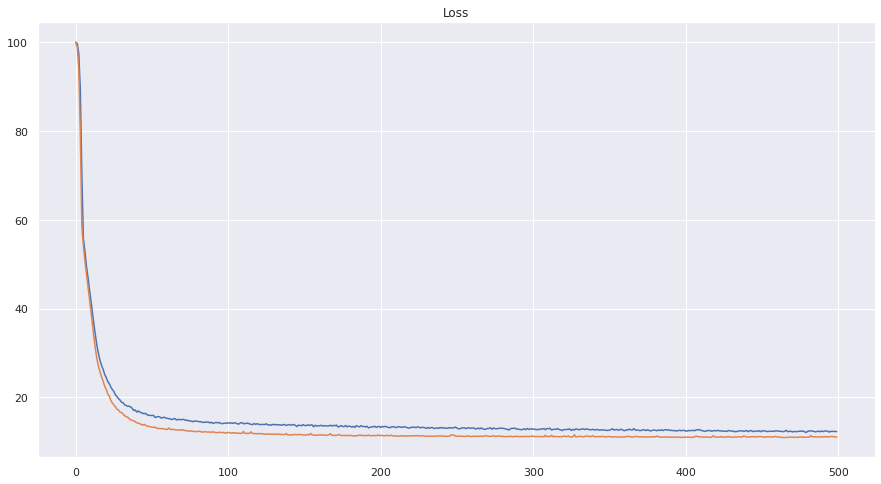

In [356]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [357]:
# model.load_weights('../working/best_model.hdf5')
# model.save('../working/nn_1.hdf5')

model.load_weights(get_model_path(environment,'best_model.hdf5'))
model.save(get_model_path(environment,'nn_1.hdf5'))

In [358]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.04%


1. TEST mape: 13.96% - дефолт
1. TEST mape: 13.31%
1. TEST mape: 12.91%
1. TEST mape: 12.87%
1. TEST mape: 11.95%
1. TEST mape: 11.50% - RobustScaler()
1. TEST mape: 11.80% - MinMaxScaler()
1. TEST mape: 11.86% - MaxAbsScaler()
1. TEST mape: 11.32% - StandardScaler(), engineDisplacement - категориальный
1. TEST mape: 11.07%
1. TEST mape: 11.19% - с предварительной очисткой description
1. TEST mape: 11.05% - без

In [359]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# ТЕСТ  

In [360]:
# import nltk
# # nltk.download('punkt')
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# # from nltk.tokenize import sent_tokenize
# stop = stopwords.words("russian")

# import pymorphy2
# import re

In [361]:
# # TOKENIZER
# # Максимальное количество используемых слов (наиболее часто)
# MAX_WORDS = 100000
# # Максимальное количество слов в предлжении
# MAX_SEQUENCE_LENGTH = 256

# # создаем единый словарь
# tokenize = Tokenizer(num_words=MAX_WORDS)
# tokenize.fit_on_texts(descriptions)

In [362]:
# # Векторизация
# text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
# text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
# text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

# print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

# Model 4: NLP + Multiple Inputs

In [363]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# from nltk.tokenize import sent_tokenize
# stop = stopwords.words("russian")



import nltk
# nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
# from nltk.tokenize import sent_tokenize
stop = stopwords.words("russian")

import pymorphy2
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Обработаем текст: 

* удалим стоп-слова
* проведём лемматизацию
* токенизируем по словам

In [364]:
data.description

0       Всем привет! Продам эксклюзивный проект 124 ун...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. Третий...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии. 3-из Авто в с...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [365]:
morph = pymorphy2.MorphAnalyzer()

def get_lemmatize(row):
    '''
    получаем лемматизированные формы слов
    '''
    text = ' '.join(morph.parse(word)[0].normal_form for word in row.split())
    # не учитываем слова короче 4 символов (предлоги, союзы)
    text = ' '.join(word for word in text.split() if len(word)>3)
    return text

def clean_text(s):
    '''
    # очистка текста перед векторизацией
    '''
    # Удалим из описаний стоп-слова
    s = s.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    # Оставим кирилицу и пробелы 
    s = s.str.replace('[^А-Яа-яЁё\s]', ' ', regex=True)
    # получаем строки из лемматизированных слов 
    s = s.apply(lambda x: get_lemmatize(x))
    return s

descriptions = clean_text(data.description)
descriptions

0       весь привет продать эксклюзивный проект универ...
1       продавать любимый тачил обвес тюнинг потому ез...
2       машина продаваться первый только перебрать дви...
3       автомобиль отличный состояние весь родный крас...
4       немка бесключивый доступ камера задний автомоб...
                              ...                        
8348    продаваться любимый автомобиль эксплуатация ма...
8349    купить официальный дилер третий владелец владе...
8350    торг место работать сборка немецкий резина лет...
8351    автомобиль отличный состояние авто семья обслу...
8352    удлинённый заводский база вообще правильно зав...
Name: description, Length: 8353, dtype: object

In [366]:
# Разделяем описания по индексам, соответствующим уже существующим наборам данных
text_train = descriptions.iloc[X_train.index]
text_test = descriptions.iloc[X_test.index]
text_sub = descriptions.iloc[X_sub.index]

### Tokenizer

In [381]:
# TOKENIZER
# Максимальное количество используемых слов (наиболее часто)
MAX_WORDS = 100000
# Максимальное количество слов в предлжении
MAX_SEQUENCE_LENGTH = 256

In [382]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(descriptions)

In [383]:
# MAX_WORDS = len(tokenize.word_index)
# tokenize = Tokenizer(num_words=MAX_WORDS)
# tokenize.fit_on_texts(descriptions)

In [384]:
# tokenize.word_index

In [385]:
# Векторизация
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)


In [386]:
# вот так теперь выглядит наш текст
print(text_train.iloc[1])
print(text_train_sequences[1])

очень красивый практически новый автомобиль кузов идеальный состояние машина полностью оклеить включая лобовой стекло полеуретановый защитный плёнка сразу покупка торг
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 

### RNN NLP

Построим рекурентную сеть без "головы":

In [387]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

Добавим к ней предыдущую сеть, которая решала табличные данные:

In [388]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [389]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

# конечная модель - 2 входа от 2-х сетей и один выход 
model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [390]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 256, 256)     3228416     seq_description[0][0]            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 256, 256)     525312      embedding_5[0][0]                
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 256, 256)     0           lstm_2[0][0]                     
_______________________________________________________________________________________

### Fit

In [391]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [392]:
# checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
# earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
# callbacks_list = [checkpoint, earlystop]


checkpoint = ModelCheckpoint(get_model_path(environment,'best_model.hdf5'), monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [393]:
%%time
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 7s 616ms/step - loss: 99.9792 - MAPE: 99.9792 - val_loss: 99.7579 - val_MAPE: 99.7579
Epoch 2/500
12/12 [==============================] - 6s 522ms/step - loss: 97.8821 - MAPE: 97.8821 - val_loss: 90.1822 - val_MAPE: 90.1822
Epoch 3/500
12/12 [==============================] - 6s 507ms/step - loss: 72.4580 - MAPE: 72.4580 - val_loss: 57.3911 - val_MAPE: 57.3911
Epoch 4/500
12/12 [==============================] - 6s 497ms/step - loss: 55.7648 - MAPE: 55.7648 - val_loss: 50.5234 - val_MAPE: 50.5234
Epoch 5/500
12/12 [==============================] - 6s 495ms/step - loss: 48.6794 - MAPE: 48.6794 - val_loss: 44.3874 - val_MAPE: 44.3874
Epoch 6/500
12/12 [==============================] - 6s 487ms/step - loss: 42.7063 - MAPE: 42.7063 - val_loss: 38.2913 - val_MAPE: 38.2913
Epoch 7/500
12/12 [==============================] - 6s 490ms/step - loss: 36.3207 - MAPE: 36.3207 - val_loss: 31.1791 - val_MAPE: 31.1791
Epoch 8/500
12/12 [========

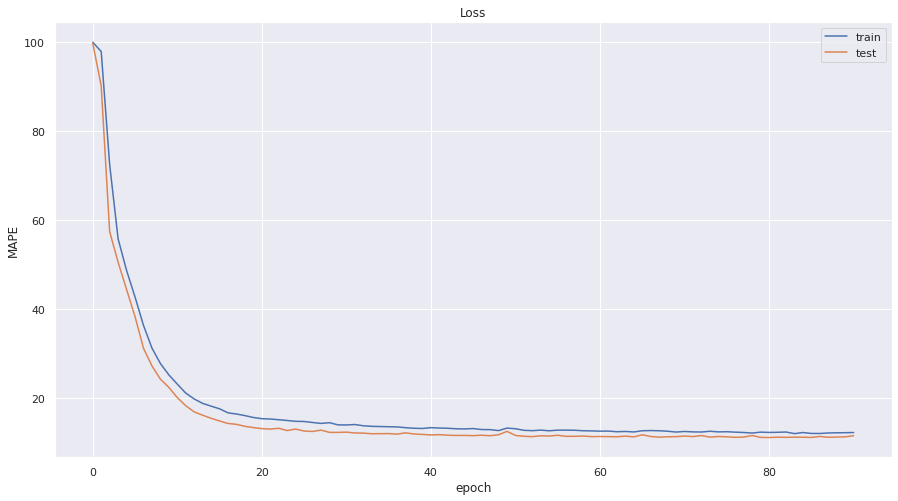

In [416]:
get_model_plot(history)

In [395]:
# model.load_weights('../working/best_model.hdf5')
# model.save('../working/nn_mlp_nlp.hdf5')


model.load_weights(get_model_path(environment,'best_model.hdf5'))
model.save(get_model_path(environment,'nn_mlp_nlp.hdf5'))

In [396]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.51%


1. TEST mape: 13.05%
1. TEST mape: 11.38% без лематизации текста
1. TEST mape: 11.54% - с очисткой и лематизацией руских
1. TEST mape: 11.59% с очисткой и лематизацией '[^\w\s]'
1. TEST mape: 11.84% - Замена частых текстов на фразу
1. TEST mape: 11.61%
1. TEST mape: 11.43% лемматизация и стоп-слова
1. TEST mape: 11.53% лемматизация и стоп-слова '[^\w\s]'
1. TEST mape: 11.36% лемматизация и стоп-слова '[^А-Яа-яЁё\s]'

In [397]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

In [ ]:
%%time
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
%%time
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

### albumentations

In [ ]:
%%time
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [ ]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [ ]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [ ]:

# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [ ]:

#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint(get_model_path(environment,'best_model.hdf5'),
                             monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
%%time
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
# model.load_weights('../working/best_model.hdf5')
# model.save('../working/nn_final.hdf5')

model.load_weights(get_model_path(environment,'best_model.hdf5'))
model.save(get_model_path(environment,'nn_final.hdf5'))

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

1. TEST mape: 11.50%
1. TEST mape: 11.34%

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

In [ ]:
sample_submission

* 11.38665 - 'nn3_submission.csv'
* 11.36465 - 'nn3_submission.csv'


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

1. TEST mape: 10.56%

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

![Снимок.JPG](attachment:c9e7ee57-a859-474c-bf5c-62f9c6591dd0.JPG)

# Model Bonus: проброс признака

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [ ]:
# X_train.modelDate

In [ ]:
# # FEATURE Input
# # Iput
# productiondate = L.Input(shape=[1], name="productiondate")
# # Embeddings layers
# emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
# f_productiondate = L.Flatten()(emb_productiondate)

# FEATURE Input
# Iput
modelDate = L.Input(shape=[1], name="modelDate")
# Embeddings layers
emb_modelDate = L.Embedding(len(X.modelDate.unique().tolist())+1, 20)(modelDate)
f_modelDate = L.Flatten()(emb_modelDate)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_modelDate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, modelDate], outputs=head)

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
X_train

In [ ]:
%%time
# history = model.fit([X_train, X_train.productionDate.values], y_train,
#                     batch_size=512,
#                     epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
#                     validation_data=([X_test, X_test.productionDate.values], y_test),
#                     callbacks=callbacks_list
#                    )


history = model.fit([X_train, X_train.modelDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.modelDate.values], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:

# model.load_weights('../working/best_model.hdf5')
model.load_weights(get_model_path(environment,'best_model.hdf5'))
test_predict_nn_bonus = model.predict([X_test, X_test.AMG.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

In [ ]:
data.productionDate.values.shape

In [ ]:
X_train.AMG.values.shape

In [ ]:
# files.download('/content/catboost_submission.csv')

In [ ]:
# 